# Final Project Jupyter Notebook

## Tennis Forehand with Changing Spin in 3D

### By: Andy Glover and Gaby Tevez

Trajectory of tennis balls in flight using the research paper "Measurements of drag and lift on tennis balls in flight" by Rod Cross and Crawford Lindsey

In [1]:
# The following import statement makes the plotting library available to us. There is also a
# statement to work around a known Jupyter bug: https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from math import sin, cos, atan2, sqrt, pi
import numpy as np

# Initial speed of tennis ball in meters per second
initial_speed = 45


# Initial angle of tennis ball in degrees from horizontal
initial_angle_from_horizontal = 6

initial_angle_xy = 90

# Simulation time step in seconds
delta_t = 0.03

# Distance to baseline in meters
distance_to_baseline = 23.77

#following variables will be used to calculate drag and lift force
coefficient_drag = 0.507
radius = 0.0335     #average radius of the tennis ball in meters
area_of_ball = pi * radius ** 2
density_of_air = 1.225   #density of air at 15 degrees celsius

# fraction of lift given to slice -- arbitrary
fraction_to_slice = 0.25

#rpm needs to converted to radians/sec
initial_rpm = 5000
conversion_to_w = pi / 30   #conversion factor 
initial_omega = conversion_to_w * initial_rpm # w is used for how fast the ball is spinning in radians per second
decline_rate = 0.02 # loses two percent of its speed for every second

mass = 0.05803  # mass of tennis balls in kg
g = 9.81


## Function to get Components of a Vector

Used from our past notebook, this is a single function that has both components returned as a tuple.


In [2]:
# computes horizontal and vertical components of a vector and returns them as a tuple
def vector_components(length, angle_from_horizontal):
    # convert angle from degrees to radians
    angle = angle_from_horizontal * pi / 180.0
    # this line is good
    horizontal_component = length * cos(angle)
    # fix the next line
    vertical_component = length * sin(angle)
    # return both components as a tuple
    return horizontal_component, vertical_component

initial_horizontal_velocity, initial_vertical_velocity = vector_components(initial_speed, initial_angle_from_horizontal)


## Functions to get Angle and Speed from Components

This function gives us the angle and the speed from the components to be used in the acceleration code


In [3]:
# sometimes we need to go from components to angle and speed -- instead of from angle and speed to components

# get angle from components using atan2 version of arctangent function
def angle_from_velocity(horizontal_velocity, vertical_velocity):
    # use the arctangent function
    angle = atan2(vertical_velocity, horizontal_velocity)  
    # we are working in degrees -- convert radians to degrees
    angle_in_degrees = angle * 180.0 / pi
    # return the result
    return angle_in_degrees

# get speed from components using Pythagorean theorem
def speed_from_velocity(horizontal_velocity, vertical_velocity):
    # pythagorean theorem
    hypotenuse = sqrt(vertical_velocity **2 + horizontal_velocity **2)
    # return the result
    return hypotenuse


# Spin Function
#### Spin is changing so we need to add the changes of spin into our coefficient of lift function

In [4]:
def spin(time):
    current_omega = initial_omega - decline_rate * time * initial_omega
    spins =  - current_omega * radius / initial_speed
    return spins


## Function to get Acceleration Components as a Tuple

This function has been substantially modified from the baseball notebook, in two ways:

* we have lift as well as drag
* we have a third axis &mdash; and have given 25% of the lift to this new axis &mdash; to capture slice

In [5]:
def acceleration_with_drag_and_lift(x_velocity, y_velocity, z_velocity, time):
    angle = angle_from_velocity(x_velocity, y_velocity)
    speed = speed_from_velocity(x_velocity, y_velocity)
    drag_strength = 0.5 * coefficient_drag * density_of_air * area_of_ball * speed ** 2 / mass
    spins = spin(time)
    coefficient_lift = 0.46 * spins
    lift_strength = 0.5 * coefficient_lift * density_of_air * area_of_ball * speed ** 2 / mass
    z_acc = fraction_to_slice * lift_strength # quite a fraction of lift to slice
    z_acc = sqrt (1 - fraction_to_slice**2) * z_acc # give remainder of lift to the x and y components
    horizontal_drag_component, vertical_drag_component =  vector_components(drag_strength, angle)
    horizontal_lift_component, vertical_lift_component =  vector_components(lift_strength, angle)
    horizontal_acc = - horizontal_drag_component - vertical_lift_component
    vertical_acc = horizontal_lift_component - vertical_drag_component - g
    return horizontal_acc, vertical_acc, z_acc

## The While Loop That Does the Work

This is also substantially similar to the baseball notebook, except that a third axis is now present.

In [6]:
# Initialize the x, y, and z velocities
x_velocities = [initial_horizontal_velocity]
y_velocities = [initial_vertical_velocity]
z_velocities = [0]
# Initialize the x, y, and z positions
x_positions = [0.0]
y_positions = [0.8] #the height where the tennis ball is first contacted
z_positions = [0.0]  
# Initialize the times
times = [0.0]

# We want to go until the tennis ball lands on the court. Add a while loop that stops 
# when the height of the ball is less than 0.
while x_positions[-1] < distance_to_baseline and y_positions[-1] > 0:
    #
    # get all the before values
    #
    # velocities
    before_x_velocity = x_velocities[-1]
    before_y_velocity = y_velocities[-1]
    before_z_velocity = z_velocities[-1]
    # positions
    before_x_position = x_positions[-1]
    before_y_position = y_positions[-1]
    before_z_position = z_positions[-1]
    # time
    before_time = times[-1]
    #
    # use the new acceleration_with_drag_and_lift function to get the accelerations
    #
    x_acceleration, y_acceleration, z_acceleration = acceleration_with_drag_and_lift(before_x_velocity, before_y_velocity, before_z_velocity, before_time)
    #
    # bog-standard Euler update code -- in two dimensions
    #
    # update the x, y, and z velocities
    after_x_velocity = before_x_velocity + delta_t * x_acceleration
    after_y_velocity = before_y_velocity + delta_t * y_acceleration
    after_z_velocity = before_z_velocity + delta_t * z_acceleration
    
    # update the x, y, and z positions
     
    after_x_position = before_x_position + delta_t * before_x_velocity
    after_y_position = before_y_position + delta_t * before_y_velocity
    after_z_position = before_z_position + delta_t * before_z_velocity
    # update time
    after_time = before_time + delta_t
    

    # append all the after values to their lists
    #
    x_velocities.append(after_x_velocity)
    y_velocities.append(after_y_velocity)
    z_velocities.append(after_z_velocity)
    x_positions.append(after_x_position)
    y_positions.append(after_y_position)
    z_positions.append(after_z_position)
    times.append(after_time)
    
    
    



## Graphs


### The Net
To creat the net, we need to create a np.arange of x and y positions to make a line in the graph. The net is 0.91 meters high and its 11.89 meters from the baseline

In [7]:
y = np.arange(0.00, 1.00, 0.01)
x = np.zeros(len(y))
for i in range (0, len(x)): 
    x[i] = 11.89

## Side View Showing X-Y Motion

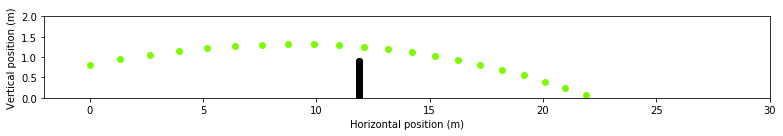

In [8]:
plt.figure(figsize=(13, 1.5))

plt.scatter(x_positions, y_positions, color ='lawngreen')

plt.scatter(x, 0.91 * y, color ='black')

plt.xlabel("Horizontal position (m)")
plt.ylabel("Vertical position (m)")

plt.xlim(-2, 30)
plt.ylim(0, 2)

plt.show()

## Top View Showing X-Z Motion  (Bird's Eye View)

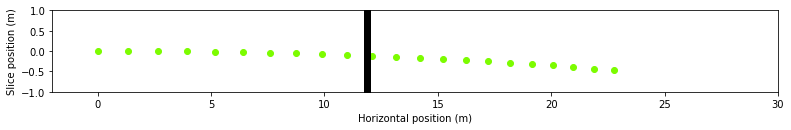

In [9]:
plt.figure(figsize=(13, 1.5))

plt.scatter(x_positions, z_positions, color ='lawngreen')

court_z_width = 2.0 # amount of the width of the court we are showing on the top view

plt.scatter(x, court_z_width * (y - 0.5), color ='black')

plt.xlabel("Horizontal position (m)")
plt.ylabel("Slice position (m)")

plt.xlim(-2, 30)
plt.ylim(-court_z_width / 2.0, court_z_width / 2.0)

plt.show()

## 3-D Plots (Hawk Eye)

We googled how to plot our data in a 3D plot. It looks a lot like a hawk eye view of the ball which in tennis can be used to challenge the referee's calls on a ball.

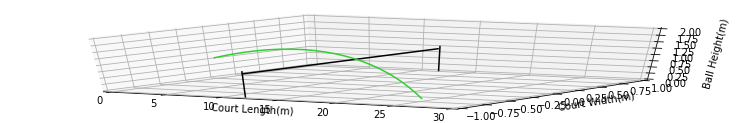

In [14]:
plt.figure(figsize=(13, 2))
b = np.zeros(len(y))
ax = plt.axes(projection='3d')
ax.plot3D(x, court_z_width * y - 1, 0.91, color ='black')
ax.plot3D(x_positions, z_positions, y_positions, 'limegreen')
ax.plot3D(x, b - 1, y, color ='black')
ax.plot3D(x, b + 1, y, color ='black')
ax.set_xlabel('Court Length(m)')
ax.set_ylabel('Court Width(m)')
ax.set_zlabel('Ball Height(m)');


ax.set_xlim(0, 30); ax.set_ylim(-1, 1); ax.set_zlim(0, 2);


## Conclusion

We have simulated both (downward) lift and slice by using a realistic function for the coefficient of lift. It is downward for topspin. The amount of slice was arbitrary. We gave 25% of the lift to the slice direction.